In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests_cache
import yfinance as yf
import torch
import torch.nn as nn

%matplotlib inline
sns.set_theme()
# device = torch.device("mps")
device = "cpu"


session = requests_cache.CachedSession("sentiment-model-4.cache")
print(device)

cpu


In [2]:
sp500_df = yf.download(
    pd.read_csv("../data/sp500-firms.csv")["Symbol"].values.tolist(),
    period="5y",
    interval="1d",
    # session=session
)
sp500_price_df = sp500_df["Close"].fillna(0)
sp500_price_df.index = pd.to_datetime(sp500_price_df.index)
sp500_price_df = sp500_price_df.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="Price")
sp500_price_df["Date"] = pd.to_datetime(sp500_price_df['Date'])
sp500_price_df = sp500_price_df[sp500_price_df["Price"] != 0]
sp500_price_df

[*********************100%%**********************]  503 of 503 completed


2 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=5y)')
['BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')


,Date,Ticker,Price
0,2018-12-03,A,74.669998
1,2018-12-04,A,72.910004
2,2018-12-06,A,71.910004
3,2018-12-07,A,70.250000
4,2018-12-10,A,70.589996
...,...,...,...
632266,2023-11-24,ZTS,180.210007
632267,2023-11-27,ZTS,178.789993
632268,2023-11-28,ZTS,176.970001
632269,2023-11-29,ZTS,175.789993


In [3]:
sp500_volume_df = sp500_df["Volume"].fillna(0)
sp500_volume_df.index = pd.to_datetime(sp500_volume_df.index)
sp500_volume_df = sp500_volume_df.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="Volume")
sp500_volume_df["Date"] = pd.to_datetime(sp500_volume_df['Date'])
sp500_volume_df

,Date,Ticker,Volume
0,2018-12-03,A,4265200.0
1,2018-12-04,A,4263800.0
2,2018-12-06,A,3505900.0
3,2018-12-07,A,2184500.0
4,2018-12-10,A,2347200.0
...,...,...,...
632266,2023-11-24,ZTS,635200.0
632267,2023-11-27,ZTS,1442700.0
632268,2023-11-28,ZTS,1348900.0
632269,2023-11-29,ZTS,1524400.0


In [4]:
sp500_df = sp500_price_df.merge(sp500_volume_df, on=["Date", "Ticker"], how="left").fillna(0)
sp500_df

,Date,Ticker,Price,Volume
0,2018-12-03,A,74.669998,4265200.0
1,2018-12-04,A,72.910004,4263800.0
2,2018-12-06,A,71.910004,3505900.0
3,2018-12-07,A,70.250000,2184500.0
4,2018-12-10,A,70.589996,2347200.0
...,...,...,...,...
624712,2023-11-24,ZTS,180.210007,635200.0
624713,2023-11-27,ZTS,178.789993,1442700.0
624714,2023-11-28,ZTS,176.970001,1348900.0
624715,2023-11-29,ZTS,175.789993,1524400.0


In [5]:
import pickle as pkl

with open("../data/post-firm-sentiment.pkl", "rb") as f:
    sentiment_df = pkl.load(f)

sentiment_df.set_index("created", inplace=True)
sentiment_df.index = sentiment_df.index.values.astype("datetime64[D]")
sentiment_df.index.name = "Date"
sentiment_df = sentiment_df.rename(columns=lambda x: x.replace("is_", ""))
sentiment_df = sentiment_df.rename(columns={"sentiment_score": "Sentiment"})
sentiment_df = sentiment_df.drop("selftext", axis=1)
sentiment_df = sentiment_df.reset_index()


tickers = sentiment_df.columns.drop(["Date", "Sentiment"])
sentiment_df = sentiment_df.melt(id_vars=["Date", "Sentiment"], var_name="Ticker", value_name="Count")
sentiment_df = sentiment_df[sentiment_df["Count"] == 1].drop("Count", axis=1).reset_index(drop=True)

sentiment_df

,Date,Sentiment,Ticker
0,2021-01-13,0.8271,A
1,2021-01-18,0.9657,A
2,2021-01-22,0.9976,A
3,2021-01-23,-0.6037,A
4,2021-01-23,0.6061,A
...,...,...,...
72833,2021-02-22,0.9136,ZTS
72834,2021-11-07,0.9303,ZTS
72835,2021-02-13,0.7345,ZTS
72836,2021-07-08,0.9796,ZTS


In [6]:
df = pd.merge(sp500_df, sentiment_df, on=["Date", "Ticker"], how="left")
df["Sentiment"] = df["Sentiment"].fillna(0)

# if a Ticker has multiple dates with sentiment, take the average of the sentiment, not the Price
df = df.groupby(["Date", "Ticker"]).mean().reset_index()
df = df[(df["Date"] >= "2021-01-01") & (df["Date"] <= "2021-12-31")].reset_index(drop=True)
df

,Date,Ticker,Price,Volume,Sentiment
0,2021-01-04,A,118.639999,2030700.0,0.796479
1,2021-01-04,AAL,15.130000,69732500.0,0.506250
2,2021-01-04,AAPL,129.410004,143301900.0,0.244350
3,2021-01-04,ABBV,105.410004,9523400.0,0.000000
4,2021-01-04,ABNB,139.149994,6409900.0,0.000000
...,...,...,...,...,...
125400,2021-12-31,YUM,138.860001,757800.0,0.000000
125401,2021-12-31,ZBH,123.339806,941008.0,0.000000
125402,2021-12-31,ZBRA,595.200012,117100.0,0.000000
125403,2021-12-31,ZION,63.160000,552900.0,0.000000


Study the following for now:
  - AAPL
  - NVDA
  - WMT
  - V
  - GOOG
  - AMZN
  - MSFT

## AAPL with sentiment

In [7]:
df_aapl = df[df["Ticker"] == "AAPL"]
df_aapl

,Date,Ticker,Price,Volume,Sentiment
2,2021-01-04,AAPL,129.410004,143301900.0,0.24435
499,2021-01-05,AAPL,131.009995,97664900.0,0.44195
996,2021-01-06,AAPL,126.599998,155088000.0,0.93435
1493,2021-01-07,AAPL,130.919998,109578200.0,0.84200
1990,2021-01-08,AAPL,132.050003,105158200.0,0.82004
...,...,...,...,...,...
122917,2021-12-27,AAPL,180.330002,74919600.0,0.96295
123415,2021-12-28,AAPL,179.289993,79144300.0,0.94080
123913,2021-12-29,AAPL,179.380005,62348900.0,0.99900
124411,2021-12-30,AAPL,178.199997,59773000.0,0.41936


In [24]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df_aapl_scaled = df_aapl.copy()
aapl_price_scaler = MinMaxScaler((-1, 1))
aapl_sentiment_scaler = MinMaxScaler((-1, 1))
aapl_volume_scaler = MinMaxScaler((-1, 1))
df_aapl_scaled["Price"] = aapl_price_scaler.fit_transform(df_aapl_scaled["Price"].values.reshape(-1, 1))
df_aapl_scaled["Sentiment"] = aapl_sentiment_scaler.fit_transform(df_aapl_scaled["Sentiment"].values.reshape(-1, 1))
df_aapl_scaled["Volume"] = aapl_volume_scaler.fit_transform(df_aapl_scaled["Volume"].values.reshape(-1, 1))
df_aapl_scaled.reset_index(drop=True, inplace=True)

In [25]:
df_aapl_scaled

,Date,Ticker,Price,Volume,Sentiment
0,2021-01-04,AAPL,-0.591996,0.324874,0.241682
1,2021-01-05,AAPL,-0.541973,-0.266154,0.440006
2,2021-01-06,AAPL,-0.679850,0.477511,0.934210
3,2021-01-07,AAPL,-0.544787,-0.111869,0.841522
4,2021-01-08,AAPL,-0.509457,-0.169111,0.819481
...,...,...,...,...,...
247,2021-12-27,AAPL,1.000000,-0.560720,0.962915
248,2021-12-28,AAPL,0.967484,-0.506007,0.940683
249,2021-12-29,AAPL,0.970299,-0.723518,0.999097
250,2021-12-30,AAPL,0.933406,-0.756878,0.417333


In [26]:
def split_data(df: pd.DataFrame, train_size: float = 0.8, lbp: int = 30, lfp: int = 1):
    """
    lbp: look back period
    lfp: look forward period
    """
    
    train_size = int(len(df) * train_size)
    train = df[:train_size]
    test = df[train_size:]

    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for i in range(lbp, train.shape[0] - lfp + 1):
        X_train.append(train.iloc[i - lbp:i, :][["Price", "Sentiment", "Volume"]].values)
        # X_train.append(train.iloc[i - lbp:i, :][["Price"]].values)
        y_train.append(train.iloc[i:i + lfp, :]["Price"].values)

    for i in range(lbp, test.shape[0] - lfp + 1):
        X_test.append(test.iloc[i - lbp:i, :][["Price", "Sentiment", "Volume"]].values)
        # X_test.append(test.iloc[i - lbp:i, :][["Price"]].values)
        y_test.append(test.iloc[i:i + lfp, :]["Price"].values)
    
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

train_size = 0.8
lookback_period = 30
lookforward_period = 1
X_train, y_train, X_test, y_test = split_data(df_aapl_scaled, train_size=train_size, lbp=lookback_period, lfp=lookforward_period)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

X_train shape: (171, 30, 3)
y_train shape: (171, 1)
X_test shape: (21, 30, 3)
y_test shape: (21, 1)


- Axis 0: Sample (window) dimension
- Axis 1: Time dimension (within window)
- Axis 2: Feature dimension (0 = price, 1 = sentiment)

In [27]:
input_size = 3 # num channels in input
num_layers = 2 # num of hidden layers
hidden_size = 32 # num of hidden nodes in each layer
output_size = lookforward_period # timesteps to predict

In [28]:
class LSTMModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, output_size: int):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_out = nn.Linear(32, output_size)
    
    def forward(self, x: torch.Tensor):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_().to(device)

        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc_out(out[:, -1, :])
        return out

In [29]:
from torch.utils.data import TensorDataset, DataLoader

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print(model)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# now that input windows are no longer grouped by company, we can shuffle the data
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=True)

LSTMModel(
  (lstm): LSTM(3, 32, num_layers=2, batch_first=True)
  (fc_out): Linear(in_features=32, out_features=1, bias=True)
)


In [30]:
from tqdm.notebook import tqdm, trange

num_epochs = 150
train_hist = []
test_hist = []

progress_bar = trange(num_epochs, desc="Epochs", postfix={"train_loss": 0.0, "test_loss": 0.0})
train_bar = tqdm(total=len(train_loader), desc="Training", leave=True)
test_bar = tqdm(total=len(test_loader), desc="Testing", leave=True)

for epoch in progress_bar:
    epoch_loss = 0.0

    # reset the progress bars
    train_bar.reset()
    test_bar.reset()

    # training loop
    model.train()
    for batch_X, batch_y in train_loader:
        # tick the progress bar
        train_bar.update()

        # forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    train_bar.refresh()
    train_hist.append(epoch_loss / len(train_loader))

    # testing loop
    model.eval()
    with torch.no_grad():
        epoch_loss = 0.0

        for batch_X, batch_y in test_loader:
            # tick the progress bar
            test_bar.update()

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            y_pred = model(batch_X)
            loss = loss_fn(y_pred, batch_y)

            epoch_loss += loss.item()
        
        test_bar.refresh()
        test_hist.append(epoch_loss / len(test_loader))

    
    # print stats
    # print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_hist[-1]} | Test Loss: {test_hist[-1]}")

    # update progress bar
    progress_bar.postfix = {"train_loss": float(f"{train_hist[-1]:.6f}"), "test_loss": float(f"{test_hist[-1]:.6f}")}

# close progress bars
train_bar.close()
test_bar.close()

Epochs:   0%|          | 0/150 [00:00<?, ?it/s, test_loss=0, train_loss=0]

Training:   0%|          | 0/22 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

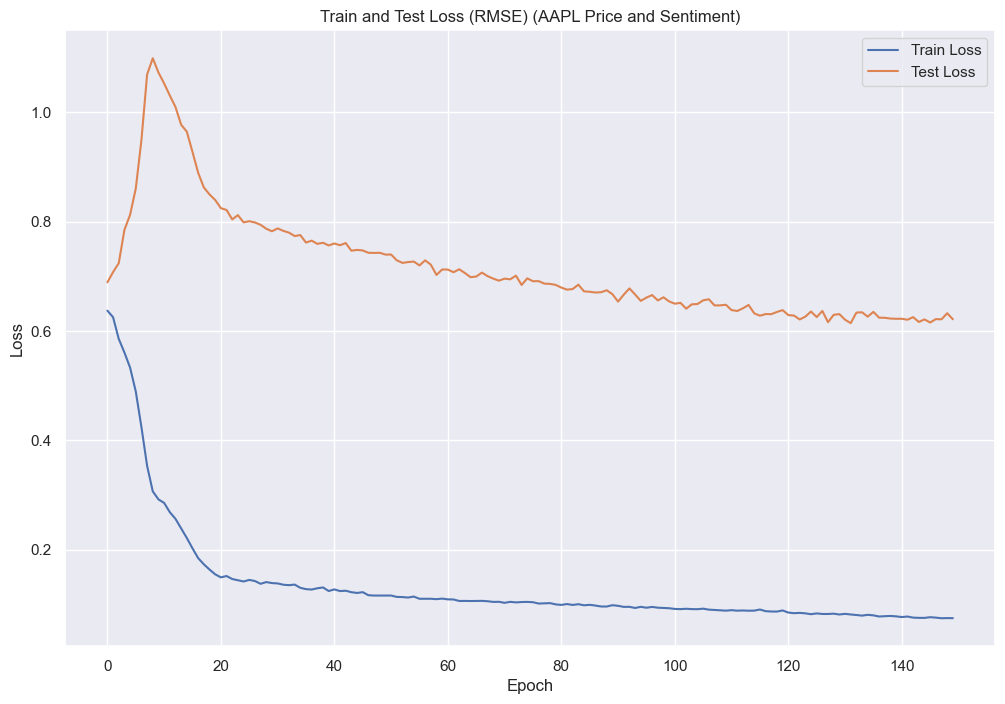

In [31]:
# plot train and test loss
train_hist = np.array(train_hist)
test_hist = np.array(test_hist)

train_rmse = np.sqrt(train_hist)
test_rmse = np.sqrt(test_hist)

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(train_rmse, label="Train Loss")
ax.plot(test_rmse, label="Test Loss")
ax.set_title("Train and Test Loss (RMSE) (AAPL Price and Sentiment)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

In [32]:
train_rmse[-1], test_rmse[-1]

(0.07493774679591307, 0.6216725705261045)

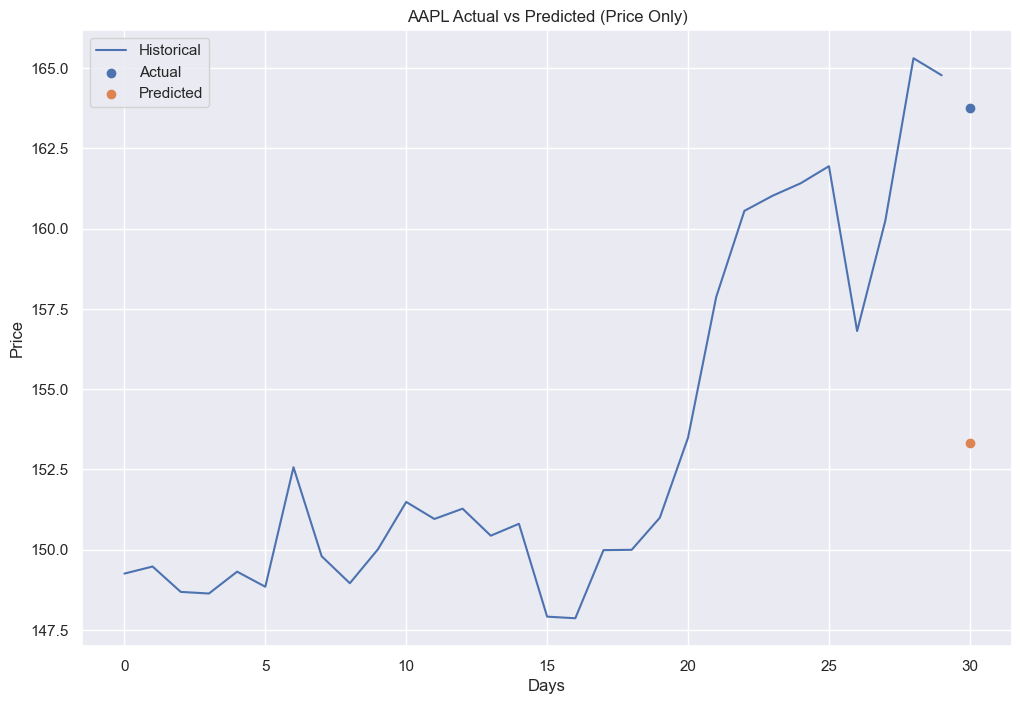

In [47]:
X = X_test.cpu().numpy()

sample = np.random.randint(0, len(X))
# sample = 0

X_sample = X[sample]
y_sample = y_test[sample].cpu().numpy()

with torch.no_grad():
    model.eval()
    y_pred = model(torch.from_numpy(X_sample.reshape(1, lookback_period, input_size)).float().to(device)).cpu().numpy()[0]

X_sample = X_sample[:, 0]

historical = aapl_price_scaler.inverse_transform(X_sample.reshape(-1, 1))
actual_future = aapl_price_scaler.inverse_transform(y_sample.reshape(-1, 1))
predicted_future = aapl_price_scaler.inverse_transform(y_pred.reshape(-1, 1))
# print(f"Actual Price: {actual_future[sample][0]}")
# print(f"Predicted Price: {predicted_future[sample][0]}")

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(historical, label="Historical")
ax.scatter(lookback_period, actual_future, label="Actual")
ax.scatter(lookback_period, predicted_future, label="Predicted")
ax.set_title("AAPL Actual vs Predicted (Price Only)")
ax.set_xlabel("Days")
ax.set_ylabel("Price")
ax.legend()